# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
filtro=2
if filtro==1:
    npzfile = np.load('../conjuntos_datos_nuevos_2020/20_12_2019_comptom_filt.npz')
    npzfile.files
    conjunto_datos_entradasA=npzfile['arr_0']
    conjunto_datos_entradasB=npzfile['arr_1']
    conjunto_datos_salidas=npzfile['arr_2']
else:
    if filtro==2:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/20_12_2019_comptom_filt2.npz')
        npzfile.files
        conjunto_datos_entradasA=npzfile['arr_0']
        conjunto_datos_entradasB=npzfile['arr_1']
        conjunto_datos_salidas=npzfile['arr_2']
    else:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
        npzfile.files
        entradas_sensorsA1=npzfile['arr_0']
        entradas_sensorsB1=npzfile['arr_1']
        coordenadas1=npzfile['arr_2']
        entradas_sensorsA2=npzfile['arr_3']
        entradas_sensorsB2=npzfile['arr_4']
        coordenadas2=npzfile['arr_5']
        conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
        conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
        conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (56839, 20, 175)
conjunto_datos_entradas B shape: (56839, 20, 175)
conjunto_datos_salidas shape: (56839, 3)


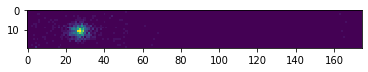

[166.55446522  57.22428188   4.93574905]


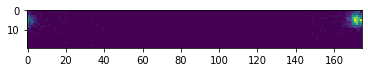

[175.53782283 351.13553053 -33.42412949]


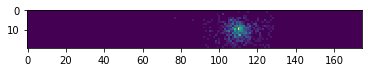

[166.06154545 224.71903329   9.34265423]


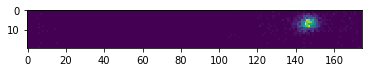

[176.98455872 300.9877457  -24.89082336]


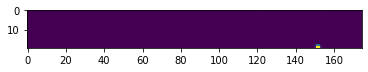

[189.57981212 309.04799896  65.43500519]


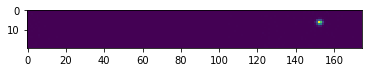

[187.68502256 310.66502523 -23.34671021]


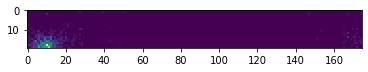

[167.1012482   16.4165904   65.37042999]


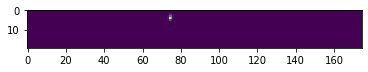

[189.72755177 150.81150772 -45.65587616]


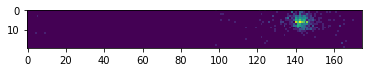

[173.2550703  290.98782997 -26.70606804]


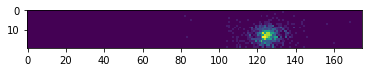

[168.20875463 254.70556476  26.74402428]


In [4]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_salidas[idea,0:3])

## Network parameters:

In [5]:

batch_size = 250
nb_classes = 10
nb_epoch = 2000

# input image dimensions
img_rows, img_cols = 20, 41
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (2, 4, 4)

## Prepare data into training and test set.

In [6]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2=np.zeros([muestras,20,175])
veamos2_3=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasA[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2A[i]=veamos2_3[i,:,indice_inferior:indice_superior]
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2B[i]=veamos2_3[i,:,indice_inferior:indice_superior]    

print('sector A shape:', sector2A.shape)
conjunto_datos_nuevoA=sector2A.reshape(sector2A.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', sector2B.shape)
conjunto_datos_nuevoB=sector2B.reshape(sector2B.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)

sector A shape: (56839, 20, 41)
conjunto_datos_nuevo A: (56839, 820)
sector B shape: (56839, 20, 41)
conjunto_datos_nuevo B: (56839, 820)


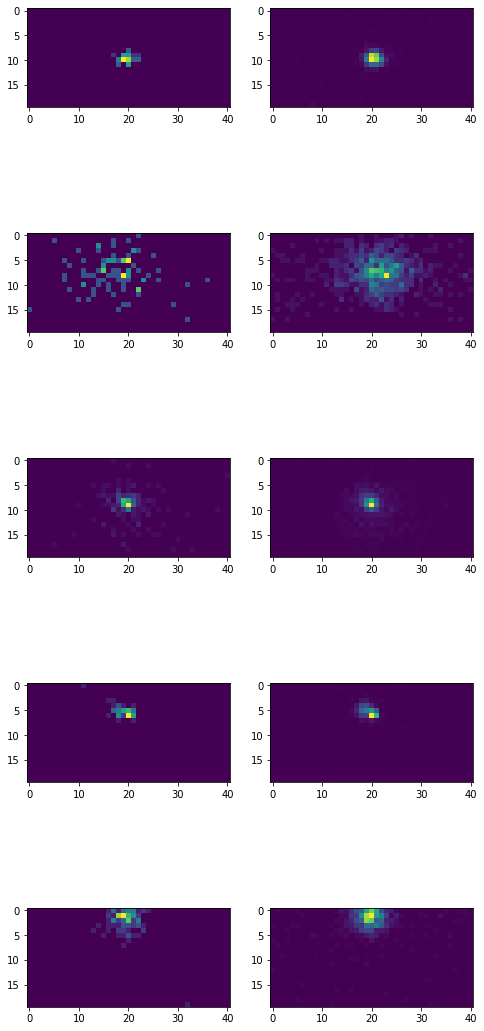

In [7]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


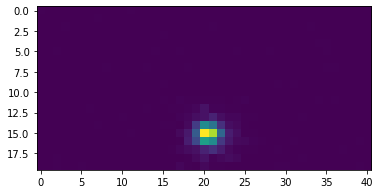

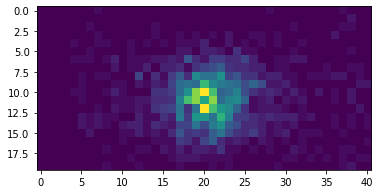

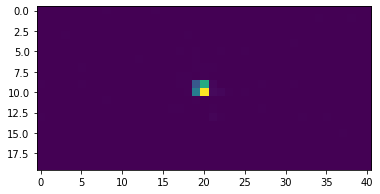

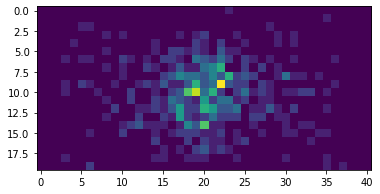

In [8]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [9]:
numero_muestras=muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

34103
11367
11369
(3816, 1640)
(2430, 1640)
(1973, 1640)
(1608, 1640)
(1542, 1640)


In [10]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols,1)

input_shape = (2, img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [11]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (34103, 2, 20, 41, 1)
34103 train samples
11367 validation samples
11369 test samples


Display 20 random training images using image

In [12]:
# # convert class vectors to binary class matrices
# #Y_train = np_utils.to_categorical(y_train, nb_classes)
# #Y_test = np_utils.to_categorical(y_test, nb_classes)
# for i in range(1,5):
#     idea=np.random.randint(1,X_train.shape[0])
#     plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
#     plt.show()

## Build the CNN. 

In [13]:
model = Sequential()

model.add(Conv3D(8, kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_last',
                        input_shape=(2,img_rows,img_cols,1)))
# model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=pool_size))

# model.add(Conv3D(32, kernel_size, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))

model.add(Conv3D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv3D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv3D(128, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('tanh'))
model.add(Dense(1))

dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}x{}_con_batchnormalization_sector_{}x{}x{}_elu".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
algoritmo='Nadam'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt)
model_check=ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 2, 20, 41, 8)      264       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 20, 41, 8)      0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 10, 20, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 10, 20, 32)     8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 10, 20, 32)     128       
_________________________________________________________________
activation_2 (Activation)    (None, 2, 10, 20, 32)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 5, 10, 32)      0         
__________

And now train the model and evaluate on the test set. 

In [15]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard,model_check,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 34103 samples, validate on 11367 samples
Epoch 1/2000
34103/34103 [==============================] - 7s 202us/step - loss: 880.2336 - val_loss: 51.8870

Epoch 00001: val_loss improved from inf to 51.88705, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_elu_Nadam_2019-12-21 13:14:00.h5
Epoch 2/2000
34103/34103 [==============================] - 4s 118us/step - loss: 18.9171 - val_loss: 31.1192

Epoch 00002: val_loss improved from 51.88705 to 31.11922, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_elu_Nadam_2019-12-21 13:14:00.h5
Epoch 3/2000
34103/34103 [==============================] - 4s 122us/step - loss: 16.5609 - val_loss: 24.8341

Epoch 00003: val_loss improved from 31.11922 to 24.83412, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4

In [16]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [17]:
best_model = load_model(best_model_name)
score = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 8.0072436439235
[169.68594 177.3615  187.54044 190.32393 171.22044 176.22856 170.68408
 174.53091 180.98355 180.26646]
[167.54586826 172.27025214 182.43029028 186.86762463 170.28600154
 172.83575396 169.46205434 168.6455402  178.11627523 179.77045368]
[-2.14007534 -5.09124383 -5.11014551 -3.4563042  -0.93444218 -3.39280744
 -1.2220277  -5.88537411 -2.86727579 -0.49601056]


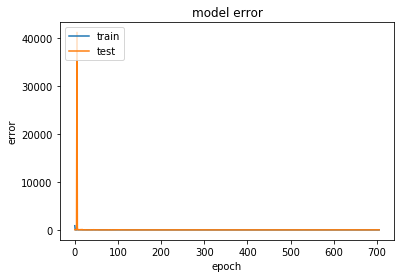

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


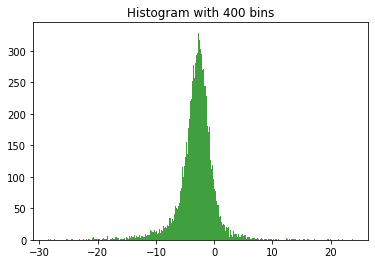

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 400
    # variables        = 3
    chi-square         = 23208.4855
    reduced chi-square = 58.4596612
    Akaike info crit   = 1630.32348
    Bayesian info crit = 1642.29787
[[Variables]]
    amp:  296.381377 +/- 1.89310399 (0.64%) (init = 1000)
    cen: -2.77464885 +/- 0.01330488 (0.48%) (init = 0)
    wid:  2.55108957 +/- 0.01881594 (0.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



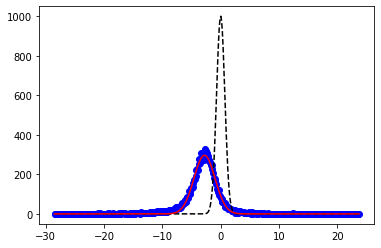

In [20]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [21]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [22]:
print(FWHM)

4.247842772636119


[[169.68594]
 [171.22044]
 [170.68408]
 ...
 [171.92656]
 [172.8454 ]
 [169.95454]]


/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.075605766001324


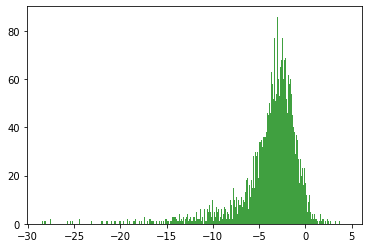

In [23]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.998254247617004


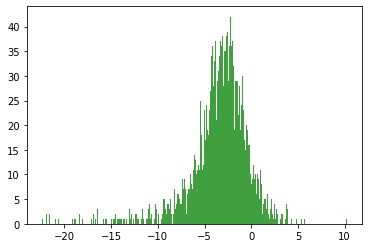

In [24]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.562616000401002


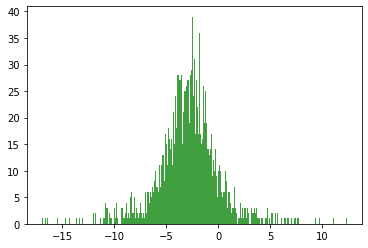

In [25]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


3.911884620802414


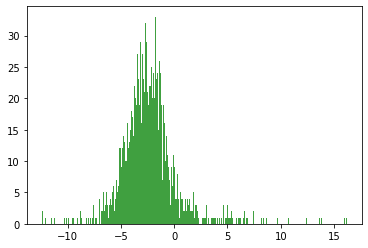

In [26]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


3.7113122928110354
3.911884620802414
4.562616000401002
4.998254247617004
4.075605766001324


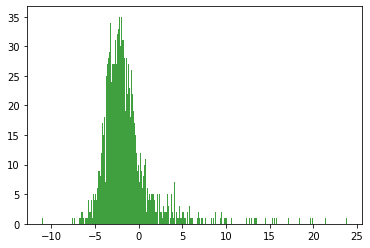

In [27]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan